# Looking at the Data

In this notebook I will be going through a dataset of Rotten Tomatoes reviews to extract the features we need for running the BERT model. We will need to make sure that we remove any null values and unnecessary details that will not be needed for running the BERT model. We will also create train, val, and test csv files for ease of use. Additionally, after splitting the data, we will make sure that the training set is properly balanced by resampling the lower of the two classes ("Fresh" & "Rotten").

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("data//rotten_tomatoes.csv").sample(frac=0.1, random_state=0).reset_index(drop=True)
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/piano_teacher,Andrew Sarris,True,Observer,Rotten,NaN,2002-04-25,Once one experiences Mr. Haneke's own sadistic...
1,m/love_songs_2008,Joseph Proimakis,False,Movies for the Masses,Fresh,3/5,2008-06-29,"Sokaristiko ohi gia tin tolmi ton eikonon, i t..."
2,m/wake_in_fright,Anton Bitel,False,Film4,Fresh,NaN,2014-03-07,derives its brand of feral menace not from mon...
3,m/mud_2012,Eric D. Snider,False,EricDSnider.com,Fresh,B+,2013-07-12,"Warm, humorous, and smart, a Huckleberry Finni..."
4,m/avengers_infinity_war,Roger Moore,False,Movie Nation,Rotten,2/4,2018-04-25,"Maybe ""Deadpool 2"" will be better..."


## Checking for Null Values

In [3]:
df.isnull().sum()

rotten_tomatoes_link        0
critic_name              1889
top_critic                  0
publisher_name              0
review_type                 0
review_score            30588
review_date                 0
review_content           6589
dtype: int64

In [4]:
df = df[["review_type","review_content"]]
df.head()

,review_type,review_content
0,Rotten,Once one experiences Mr. Haneke's own sadistic...
1,Fresh,"Sokaristiko ohi gia tin tolmi ton eikonon, i t..."
2,Fresh,derives its brand of feral menace not from mon...
3,Fresh,"Warm, humorous, and smart, a Huckleberry Finni..."
4,Rotten,"Maybe ""Deadpool 2"" will be better..."


In [5]:
print(f'Number of classes: {df["review_type"].nunique()}')

Number of classes: 2


In [6]:
print(f'Size of the Dataset: {len(df)}')

Size of the Dataset: 113002


In [7]:
df.isnull().sum()

review_type          0
review_content    6589
dtype: int64

<AxesSubplot:xlabel='review_type', ylabel='count'>

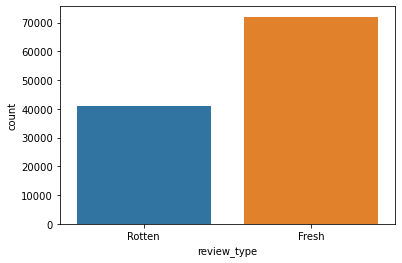

In [8]:
sns.countplot(x="review_type", data=df)

In [9]:
df = df.dropna()
df.isnull().sum()

review_type       0
review_content    0
dtype: int64

<AxesSubplot:xlabel='review_type', ylabel='count'>

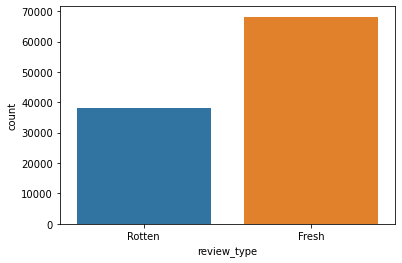

In [10]:
sns.countplot(x="review_type", data=df)

## Checking the Maximum Word Count

**NOTE:** The BERT model we will be applying to this dataset has a maximum word count of 512. We want to make sure that our reviews fall below that threshold. If the text is too long we will need to truncate them.

In [11]:
def df_word_count(df,text_column:str):
    max_count = 0
    count_list = []
    id_max = None
    for idx, text in enumerate(df[text_column]):
        word_count = len(text.strip().split(" "))
        count_list.append(word_count)
        if word_count > max_count:
            max_count = word_count
            id_max = idx
            
    count_dict = {'max_count':max_count,
                  'id_max':id_max,
                  'count_list':count_list,}
    return count_dict

In [12]:
count_dict = df_word_count(df, "review_content")

In [13]:
print(f'Max Count for Review Contents: {count_dict["max_count"]}')
print(f'ID for Max Count: {count_dict["id_max"]}')

Max Count for Review Contents: 54
ID for Max Count: 96412


In [14]:
df["review_content"][count_dict["id_max"]]

'Both of the leads do well in their roles, but since the movie is so predictable and some of the attempts at humor go south, most of it just leave you smacking your palm against your forehead.'

# Label Encoding the Reviews

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
le = LabelEncoder()
le.fit(df["review_type"])
labels = le.transform(df["review_type"])
df["labels"] = labels

In [17]:
df = pd.DataFrame(df, columns=["labels", "review_type", "review_content"])
df.head()

,labels,review_type,review_content
0,1,Rotten,Once one experiences Mr. Haneke's own sadistic...
1,0,Fresh,"Sokaristiko ohi gia tin tolmi ton eikonon, i t..."
2,0,Fresh,derives its brand of feral menace not from mon...
3,0,Fresh,"Warm, humorous, and smart, a Huckleberry Finni..."
4,1,Rotten,"Maybe ""Deadpool 2"" will be better..."


In [18]:
for i, label in enumerate(le.classes_):
    print(f'Label {label} encoded as {i}')

Label Fresh encoded as 0
Label Rotten encoded as 1


## Splitting the Data for Further Processing

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [20]:
train_dev_ratio = 0.8
val_test_ratio = 0.5
random_state = 42

train, dev = train_test_split(df, train_size = train_dev_ratio, random_state = random_state)
val, test = train_test_split(dev, train_size = val_test_ratio, random_state = random_state)

In [21]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [22]:
train.head()

,labels,review_type,review_content
0,0,Fresh,Captures the tone and spirit of the original.
1,1,Rotten,"Introspective is one thing, but this tormented..."
2,0,Fresh,"Charles Bronson may have passed away, but the ..."
3,0,Fresh,You are unlikely to find another contemporary ...
4,0,Fresh,Real Steel is much like Atom: clunky and a lit...


<AxesSubplot:xlabel='review_type', ylabel='count'>

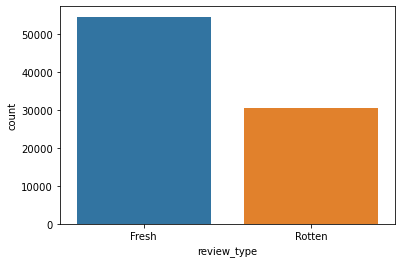

In [23]:
sns.countplot(x="review_type", data=train)

In [24]:
train_fresh = train[train["review_type"]=="Fresh"]
train_rotten = train[train["review_type"]=="Rotten"]

In [25]:
print(f'Length of Fresh Reviews: {len(train_fresh)}')
print(f'Length of Rotten Reviews: {len(train_rotten)}')

Length of Fresh Reviews: 54599
Length of Rotten Reviews: 30531


In [26]:
train_rotten_upsampled = resample(train_rotten,replace=True,n_samples=len(train_fresh),random_state=42)
print(f'Length of Upsampled Rotten Reviews: {len(train_rotten_upsampled)}')

Length of Upsampled Rotten Reviews: 54599


<AxesSubplot:xlabel='review_type', ylabel='count'>

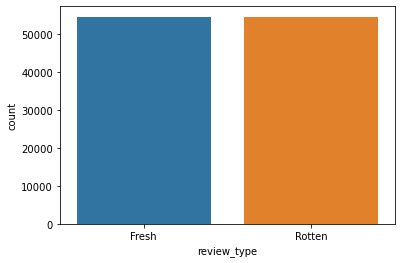

In [27]:
train_balanced = pd.concat([train_fresh, train_rotten_upsampled])
sns.countplot(x="review_type", data=train_balanced)

# Saving Dataframes

In [28]:
train_balanced.to_csv('data//train.csv',index=False)
val.to_csv('data//val.csv',index=False)
test.to_csv('data//test.csv',index=False)